In [1]:
# ensure we're using pytorch
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [2]:
# import libraries
import pandas as pd
import re
import torch
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments
from datasets import load_metric
from torch.nn import CrossEntropyLoss
from torch import tensor

# Problem Statement and Approach

In light of many GenAI technologies, there are an increasing number of fake job postings getting posted to our job board website which is causing job seekers loose trust in our website and job postings. Identifying fake job postings will be critical for building user trust as well as customer trust.

Job postings are text heavy and Natural Language Processing (NLP) provides an effective method for assessing job posting content. We'll aim to utilize DistilBERT, a transformer-based model to classify job postings. By fine tuning the DistilBERT model on labeled job posting data, our team will aim to build a classification model to deploy to our job search website to detect fake job postings. 

# Data Understanding (EDA)

With the fake job postings dataset, we will proceed with exploratory data analysis. We'll start by reviewing some initial records to get an idea of how each record is stored and check the columns available in the dataset. 

In [3]:
# Load dataset
df = pd.read_csv('fake_job_postings.csv')

In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
df.columns.tolist()

['job_id',
 'title',
 'location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'fraudulent']

After analyzing the columns within the dataset, we'll proceed with check for missing values so we can properly handle those missing values while training our model.

In [6]:
# check for missing data
missing_data = df.isnull().mean().sort_values(ascending=False)

missing_data

salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403356
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150783
location               0.019351
description            0.000056
job_id                 0.000000
telecommuting          0.000000
has_questions          0.000000
has_company_logo       0.000000
title                  0.000000
fraudulent             0.000000
dtype: float64

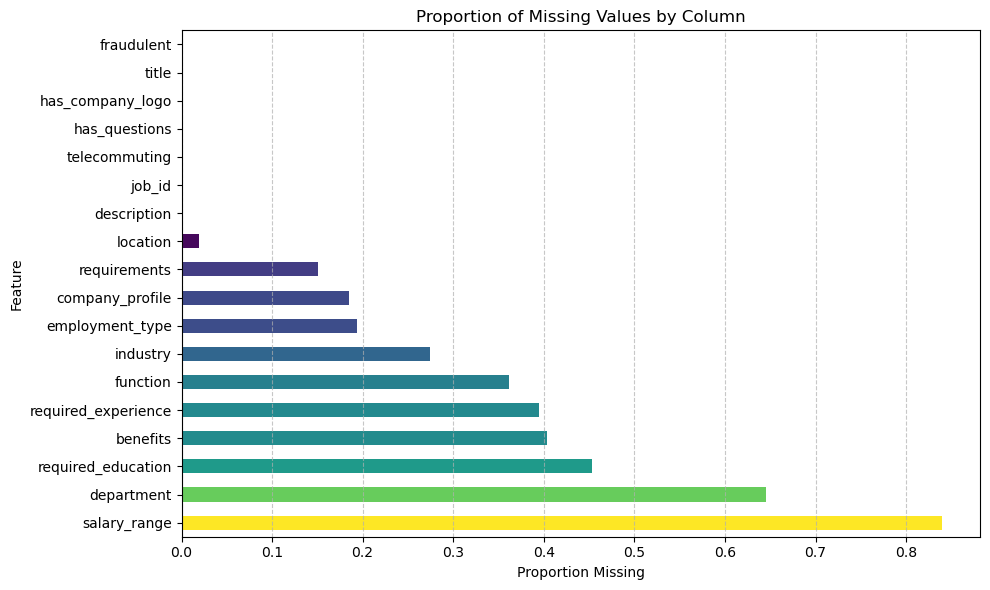

In [7]:
# adding colors to bars for ease of visualization
colors = plt.cm.viridis(missing_data.values / max(missing_data.values))

# plot missing values
plt.figure(figsize=(10, 6))
missing_data.plot(kind='barh', color=colors)
plt.title('Proportion of Missing Values by Column')
plt.xlabel('Proportion Missing')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

When visualizing the missing values plot, it's much easier to identify which datapoints are missing. We can deduce whether or not we are missing essential components of a job posting and use that to judge whether it's a good idea to drop missing values or apply some imputation as the missing values could prove important for detecting fake jobs. Reviewing the plot, we can see that we're not missing any values from the target class, title, job id, and description which are all important details of a job posting. From the columns with missing data, it is suprising to see missing values for requirements and company profile which we would assume are important elements of a job posting. This could be useful for identifying fake jobs postings.

Now that we know there are some job postings with important information missing, we can check for text length within those fields we believe to be important for real job postings. We decided to inspect job title, job description, job requirements, and company profile to see if there are any strange outliers or suprising insights from what we might expect. We would expect that job description would be the longest text out of the four fields as a quality job posting would ensure to thorougly explain the job requirements. 

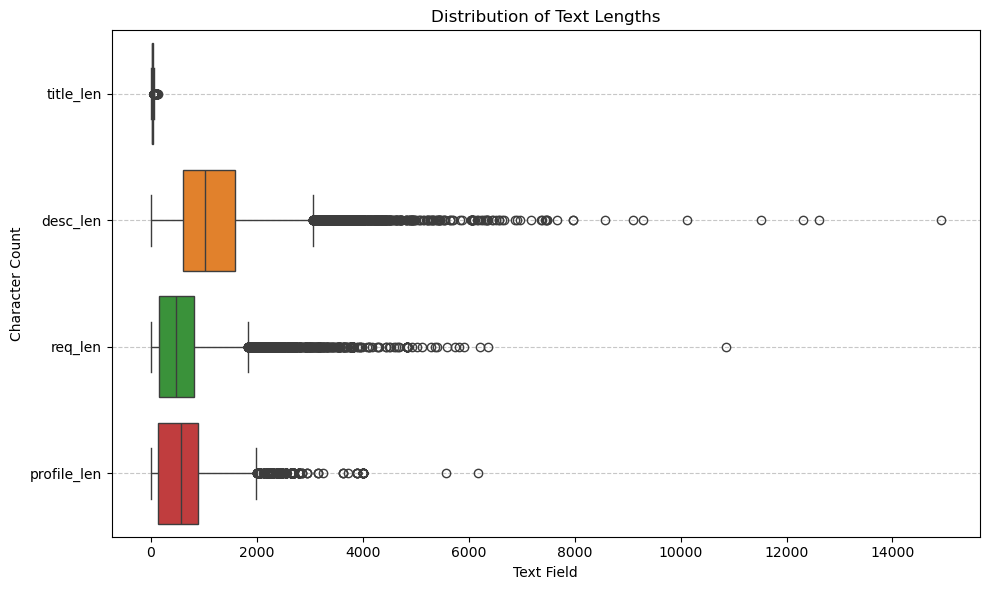

In [14]:
# check text length (these can be used as engineered features)
df['title_len'] = df['title'].apply(lambda x: len(str(x)))
df['desc_len'] = df['description'].apply(lambda x: len(str(x)))
df['req_len'] = df['requirements'].apply(lambda x: len(str(x)))
df['profile_len'] = df['company_profile'].apply(lambda x: len(str(x)))

# plot text length
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['title_len', 'desc_len', 'req_len', 'profile_len']], orient='h')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Field')
plt.ylabel('Character Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The boxplot provides a clear picture of outliers and the Interquartile Range (IQR) give good guidence on the spread of text length for the important fields. As expected, the job description tends to be the longest text in the job posting with some clear outliers being almost seven times longer than the median job description length. Job titles are relatively short as we would expect with several outliers which may be worth investigating. There are some outliers requirements and profile lengths as well. 

It would also be good to get a visualization of the distribution of the text lengths as well. 

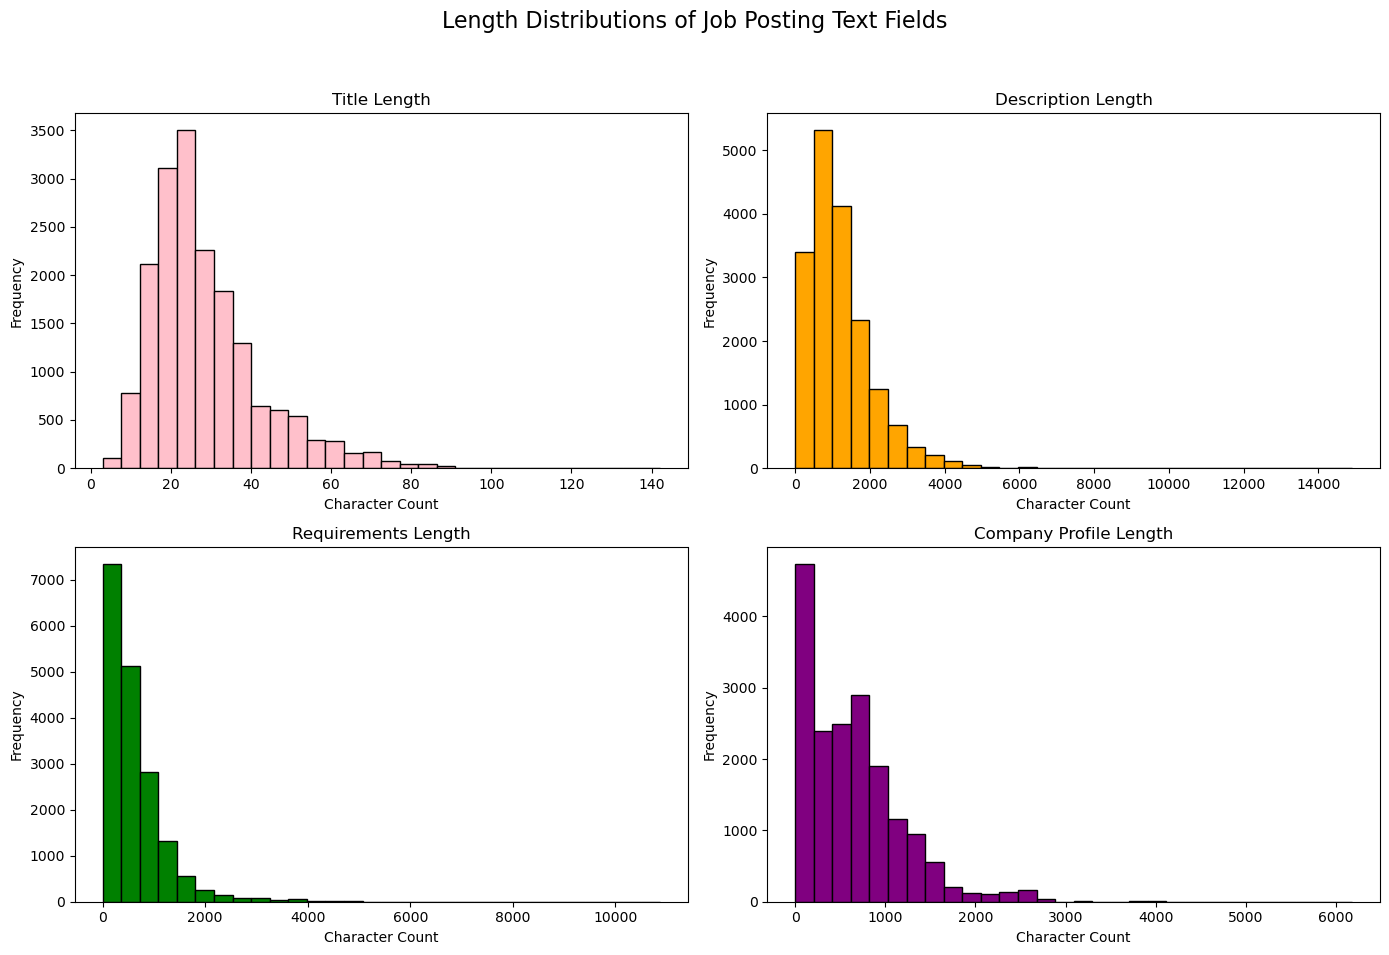

In [13]:
# compute field length accounting for missing values
df['title_length'] = df['title'].fillna('').apply(len)
df['description_length'] = df['description'].fillna('').apply(len)
df['requirements_length'] = df['requirements'].fillna('').apply(len)
df['company_profile_length'] = df['company_profile'].fillna('').apply(len)

# plot field length distributions
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Length Distributions of Job Posting Text Fields', fontsize=16)

# Plot histograms
axs[0, 0].hist(df['title_length'], bins=30, edgecolor='black', color='pink')
axs[0, 0].set_title('Title Length')

axs[0, 1].hist(df['description_length'], bins=30, edgecolor='black', color='orange')
axs[0, 1].set_title('Description Length')

axs[1, 0].hist(df['requirements_length'], bins=30, edgecolor='black', color='green')
axs[1, 0].set_title('Requirements Length')

axs[1, 1].hist(df['company_profile_length'], bins=30, edgecolor='black', color='purple')
axs[1, 1].set_title('Company Profile Length')

for ax in axs.flat:
    ax.set_xlabel('Character Count')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The text length distribution does provide a clearer picture of these job fields and shows that job descriptions are generally longer than job requirements and company profiles. Nothing suprising with majority of job ittles lower than 60 characters with some outlier job titles being longer than 80 characters. Those may be questionable jobs. The large number of job descriptions and job requirements with character lengths close to zero is alarming which indicates there are many job postings without these fields. We could consider makingn these fields required in order for the job to be posted on our website in order to ensure more quality job posts are being posted for job seekers. 

With a good idea of all the columns in the dataset, we'll proceed to check the target class for any imbalances. This will provide a clear picture of how the target class needs to be handled via the model training to ensure imbalances are accounted for.

In [32]:
# check class balance for fake vs real
class_counts = df['fraudulent'].value_counts()

print(class_counts)

fraudulent
0    17014
1      866
Name: count, dtype: int64


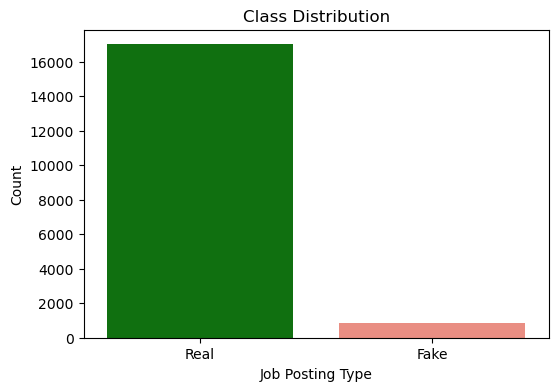

In [33]:
# set class field to string
df['fraudulent'] = df['fraudulent'].astype(str)

# plot class balance
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fraudulent', hue='fraudulent', palette={'0': 'green', '1': 'salmon'}, legend=False)
plt.title('Class Distribution')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.xlabel('Job Posting Type')
plt.ylabel('Count')
plt.show()

With the number of real job postings of 17014 and the number of fake job postings of 866, this equates to roughly 4.8% of all job postings being fake in our dataset. There is clear class imbalance which is a good thing because we would expect a very small percentage of job postings are fake. This means we will need to account for class imbalance while training our model to ensure there is not an overfitting issue to the majority class. Overfitting can cause accuracy to be extremely inflated and inaccurate and we will need to pay attention to other performance metrics such as precision, recall, and F1-scores. 

# Data Preparation & Feature Engineering

From our exploratory data analysis, we discovered there were missing data for many of the fields in a job posting. For modeling purposes, we will fill in missing values with "Unknown" as missing values from job descriptions or job titles could be a signal of fake jobs.

In [15]:
# missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)

# fill categorical columns with "unknown"
categorical_fill = ['department', 'salary_range', 'company_profile', 'requirements',
                    'benefits', 'employment_type', 'required_experience', 
                    'required_education', 'industry', 'function', 'location', 'description', 'title']

df[categorical_fill] = df[categorical_fill].fillna("Unknown")

# output results
remaining_missing = df.isnull().sum()
print("\nMissing values after filling:")
print(remaining_missing[remaining_missing > 0] if remaining_missing.sum() > 0 else "No missing values remaining.")


Missing values after filling:
No missing values remaining.


We were able to successfully fill in missing values with "Unknown" if the fields were missing from the job posting. 

We initially recognized there were outliers for job title, job description, job requirements, and company profile. We will plot histograms of those fields with clear splits for the upper 95th percentile which would indicator outliers for text length.

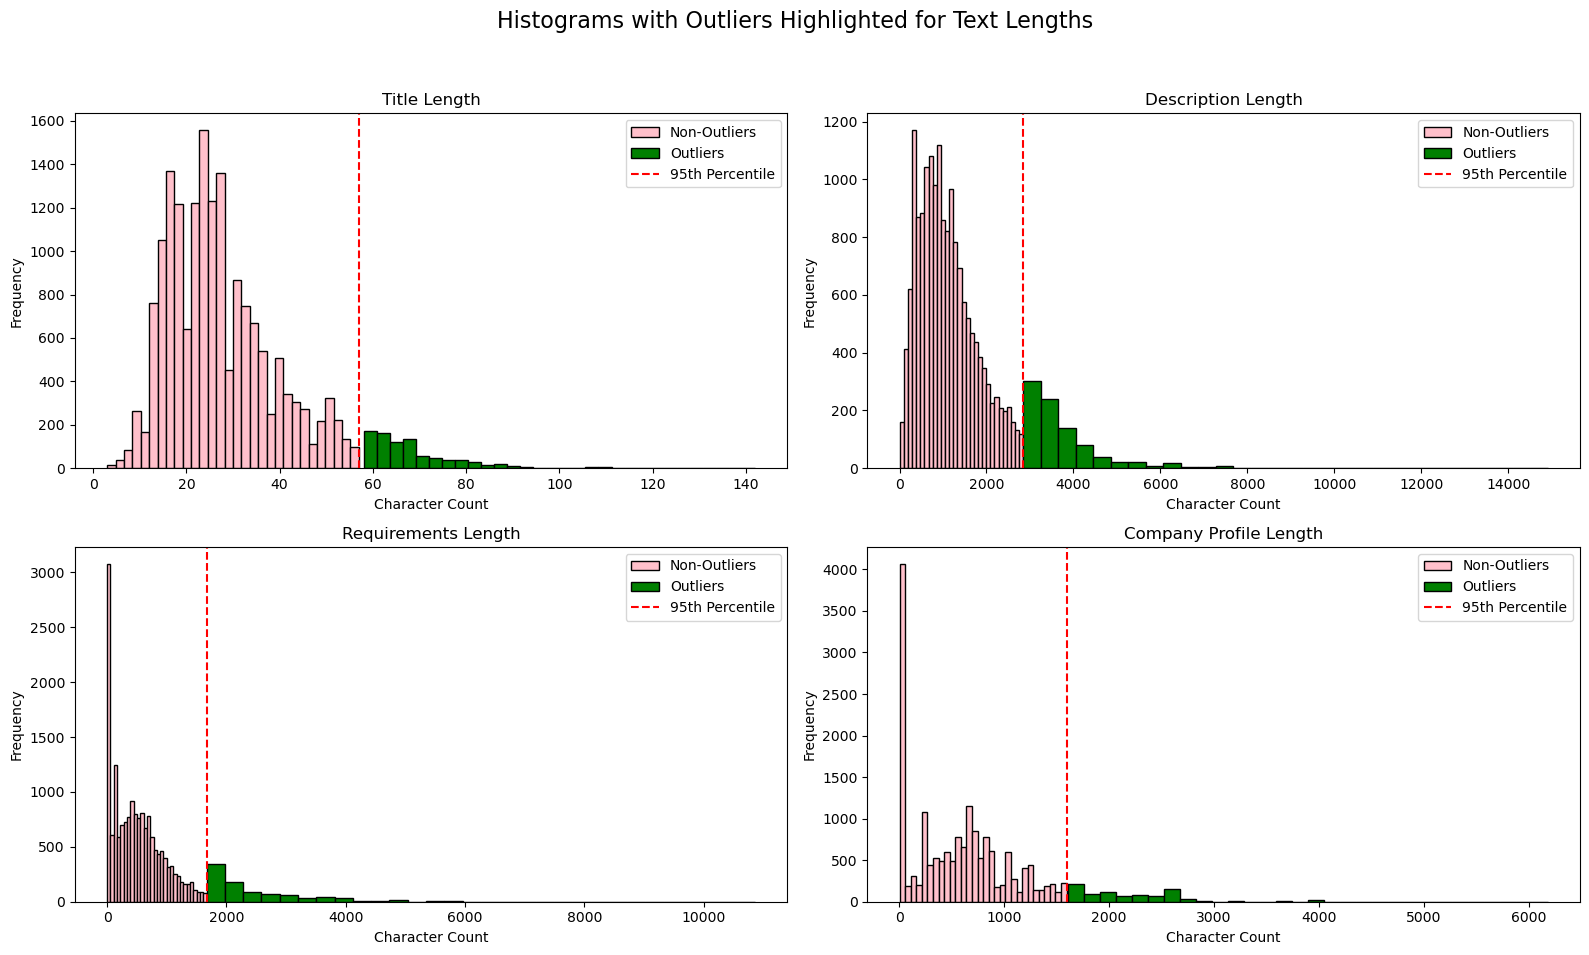

In [18]:
# visualizing outliers
fields = {
    'title_len': 'Title',
    'desc_len': 'Description',
    'req_len': 'Requirements',
    'profile_len': 'Company Profile'
}

# create subplot
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Histograms with Outliers Highlighted for Text Lengths', fontsize=16)

# plot histogram of outliers
for ax, (col, label) in zip(axs.flat, fields.items()):
    threshold = df[col].quantile(0.95)
    outliers = df[df[col] > threshold]
    non_outliers = df[df[col] <= threshold]
    
    ax.hist(non_outliers[col], bins=30, color='pink', edgecolor='black', label='Non-Outliers')
    ax.hist(outliers[col], bins=30, color='green', edgecolor='black', label='Outliers')
    ax.axvline(threshold, color='red', linestyle='--', label='95th Percentile')
    
    ax.set_title(f'{label} Length')
    ax.set_xlabel('Character Count')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can clearly see the divide between the outlier text lengths for the fields now. We will proceed with additional analysis on these outliers and the impacts they have on real or fake job profiles. This can provide critical insights into what factors might lead to fraudulent job postings.

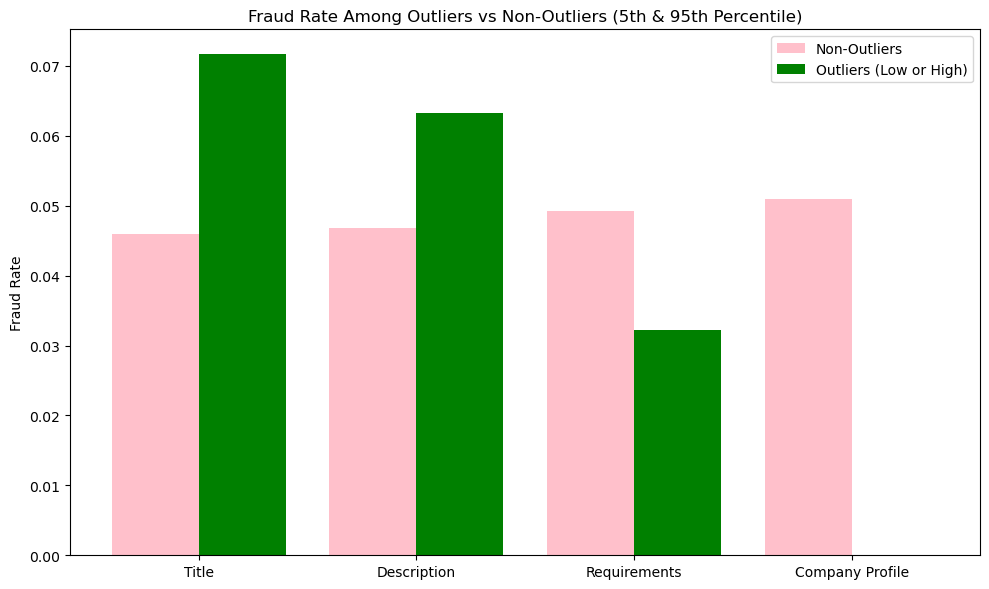

In [23]:
# we will identify 2 outlier thresholds for long text and short text lengths
fraud_comparison = {}

for col in ['title_len', 'desc_len', 'req_len', 'profile_len']:
    low_threshold = df[col].quantile(0.05)
    high_threshold = df[col].quantile(0.95)

    # identify low or long text
    df[f'{col}_outlier'] = ((df[col] < low_threshold) | (df[col] > high_threshold)).astype(int)

    # calculate fraud rate for outliers
    rates = df.groupby(f'{col}_outlier')['fraudulent'].mean()
    fraud_comparison[col] = rates

# convert to df for plots
fraud_rate_df = pd.DataFrame(fraud_comparison).T
fraud_rate_df.columns = ['Non-Outlier Fraud Rate', 'Outlier Fraud Rate']
fraud_rate_df = fraud_rate_df.reset_index().rename(columns={'index': 'Field'})

# plot fraud rates for outliers
plt.figure(figsize=(10, 6))
x = range(len(fraud_rate_df))
plt.bar(x, fraud_rate_df['Non-Outlier Fraud Rate'], width=0.4, label='Non-Outliers', align='center', color='pink')
plt.bar([p + 0.4 for p in x], fraud_rate_df['Outlier Fraud Rate'], width=0.4, label='Outliers (Low or High)', align='center', color='green')
plt.xticks([p + 0.2 for p in x], ['Title', 'Description', 'Requirements', 'Company Profile'])
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate Among Outliers vs Non-Outliers (5th & 95th Percentile)')
plt.legend()
plt.tight_layout()
plt.show()


From the above plot, we can see there are slightly more fake job postings compared to real job postings for jobs with outlier job title and job description text lengths. Overall, there is not much in the way of drastic differences in fake or real job postings for the outlier values. This is suprising considering we are accounting for the lower 5% of text lengths. This might indicate job posters are not doing a good job of filling out the details and we may want to update some of our jon posting requirements.

# Feature Selection & Modeling

In [39]:
# reset target column to int
df['fraudulent'] = df['fraudulent'].astype(int)

# for the initial DistilBERT, let's start with just the job description and target column
df_model = df[['description', 'fraudulent']].copy()

df_model.head()


,description,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0


In [40]:
# split data to train/val/test - we'll use 80/10/10
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_model['description'].tolist(),
    df_model['fraudulent'].tolist(),
    test_size=0.2,
    stratify=df_model['fraudulent'],
    random_state=100
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=100
)


In [41]:
# we're using DistilBERT, let's load in tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# tokenize datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")


In [42]:
# create PyTorch Dataset
class JobDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# wrap each dataset
train_dataset = JobDataset(train_encodings, train_labels)
val_dataset = JobDataset(val_encodings, val_labels)
test_dataset = JobDataset(test_encodings, test_labels)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# check dataset sizes
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 14304
Validation size: 1788
Test size: 1788


In [43]:
# use GPU if we can
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [44]:
# load in DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2 
)
model.to(device)

# set optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# handle class imbalance with class weights
train_label_counts = np.bincount(train_labels)
class_weights = [1.0 / c for c in train_label_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# create trainer with weight loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # apply weighted loss
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [48]:
# load accuracy
accuracy_metric = load_metric("accuracy")

# create compute_metrics functions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# define training parameters
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# train the model
trainer.train()

C:\Users\Donva\AppData\Local\Temp\ipykernel_19820\1636435234.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.647800,0.484492,0.974273
2,0.332400,0.350115,0.968121
3,0.147100,0.470298,0.979306


TrainOutput(global_step=2682, training_loss=0.3757839956717381, metrics={'train_runtime': 1194.8228, 'train_samples_per_second': 35.915, 'train_steps_per_second': 2.245, 'total_flos': 5684441011126272.0, 'train_loss': 0.3757839956717381, 'epoch': 3.0})

In [49]:
# predict on test data
predictions = trainer.predict(test_dataset)

# store predictions
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# create classification report
report = classification_report(y_true, y_pred, target_names=["Real", "Fake"])
print(report)

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      1702
        Fake       0.77      0.84      0.80        86

    accuracy                           0.98      1788
   macro avg       0.88      0.91      0.90      1788
weighted avg       0.98      0.98      0.98      1788



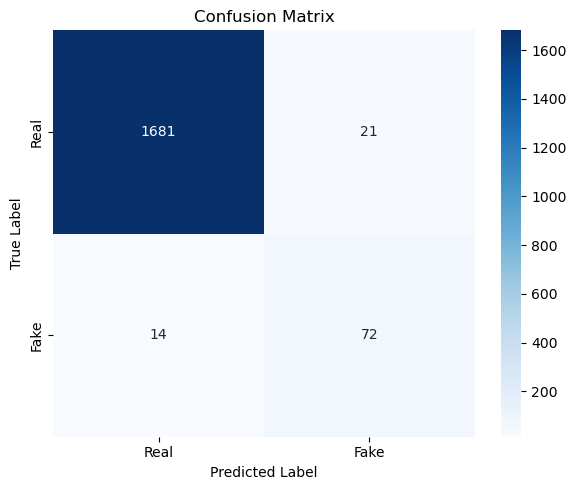

In [50]:
# define confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Matthew's Model Code

In [ ]:
# Stopwords list
stopwords = set([
    "a", "an", "the", "and", "or", "but", "if", "while", "with", "without",
    "in", "on", "at", "to", "from", "by", "for", "of", "as", "is", "are", "was",
    "were", "be", "been", "being", "this", "that", "these", "those", "it", "its",
    "he", "she", "they", "them", "his", "her", "their", "you", "your", "we", "us"
])

In [ ]:
# Clean text
def preprocess_text(text):
    text = text.lower()
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    return ' '.join([t for t in tokens if t not in stopwords])

In [ ]:
# Prepare input text
df['text'] = df[['description', 'requirements', 'company_profile']].fillna('').agg(' '.join, axis=1)
df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
# Load Hugging Face model and tokenizer
print("Loading transformer model...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")
model.eval()


In [ ]:
# Function to get mean pooled embedding
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
# Generate embeddings for each job posting
print("Generating embeddings...")
embeddings = np.vstack([get_embedding(text) for text in tqdm(df['clean_text'])])

In [ ]:
# TF-IDF feature extraction
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['clean_text'])

In [ ]:
# LDA topic modeling
print("Running LDA topic modeling...")
count_vectorizer = CountVectorizer(max_features=1000)
count_matrix = count_vectorizer.fit_transform(df['clean_text'])
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(count_matrix)

In [ ]:
# Combine features
print("Combining features...")
X_combined = hstack([tfidf_features, lda_topics, embeddings])
y = df['fraudulent']

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Train classifier
print("Training classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

In [ ]:
# Predictions and report
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluation

# Deployment

# Discussion and Conclusions